In [68]:
import sys
from astropy.io import fits
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u #currently not used
import mask_obj_node as maskNode
import mask_obj_node_tree as maskTree
import process_cube
fil_finder_dir = '/Users/larryli/Documents/CC/16-17/research/GALFA_filfind/fil_finder'
sys.path.append(fil_finder_dir)
import filfind_class as filfind
%matplotlib inline
print "YES"

YES


In [123]:
cube_dir = '../data/'
cube_name = 'usharpbg30.fits'

'''
v_range = [12,21]
y_range = [850, 1120]
y_dim = y_range[1] - y_range[0]
x_range = [2230, 2600]
x_dim = x_range[1] - x_range[0]
'''

v_range = [6,10]
y_range = [750, 950]
y_dim = y_range[1] - y_range[0]
x_range = [1900, 2600]
x_dim = x_range[1] - x_range[0]

In [127]:
full_cube, hdr = fits.getdata(cube_dir + cube_name, header=True)

# full cube dimentions
full_cube_shape = full_cube.shape
full_v_channel_count = full_cube_shape[0]
full_y_pixel_count = full_cube_shape[1]
full_x_pixel_count = full_cube_shape[2]

# cut cube based on provided x&y dimentions
cut_cube = full_cube[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]

	There are 36 velocity channels in total
	The full image is 2600 by 1150 pixels
	Processing x=[1900, 2600], y=[750, 950] in v=[6, 10]

	working on velocity slice 6
number of objects: 12

	working on velocity slice 7
number of objects: 10

	working on velocity slice 8
number of objects: 11

	working on velocity slice 9
number of objects: 9
saving struct at pickled_dicts/usharpbg30[6, 10][1900, 2600][750, 950].p


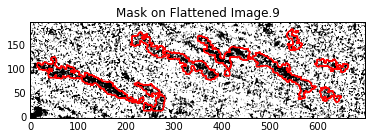

In [124]:
reload(filfind)
reload(process_cube)

pickle_save_path = process_cube.process_cube_filfind_struct(cube_dir, cube_name, v_range, x_range, y_range)

In [125]:
recover_pickle_path1 = 'pickled_dicts/usharpbg30[0, 36][1300, 2600][600, 1150].p'
recover_pickle_path2 = 'pickled_dicts/usharpbg30[5, 12][1600, 2400][600, 1100].p'
recover_pickle_path3 = 'pickled_dicts/usharpbg30[6, 10][1900, 2600][750, 950].p'

recover_path = recover_pickle_path3

In [126]:
#recover pickle
nodes_by_v_slice = pickle.load( open(recover_path, 'rb'))

In [113]:
reload(maskNode)
reload(maskTree)

<module 'mask_obj_node_tree' from 'mask_obj_node_tree.pyc'>

In [114]:
def newTreeFromNode(node):
    print "\t   NEW TREE!"
    node.visited = True
    new_tree = maskTree.MaskObjNodeTree(node)
    return new_tree

In [132]:
# this assume the input tree is just the root
def findAllChildren(tree, overlap_thresh):
    start_v = tree.root_v_slice
    v_slice = start_v + 1
    while v_slice < v_range[1]:
        if v_slice not in nodes_by_v_slice or len(nodes_by_v_slice[v_slice]) == 0:
            tree.has_ended = True
            break
        else:
            children_added = []
            #sort keys in descending valye
            for i in sorted(nodes_by_v_slice[v_slice].keys(), reverse=True):
                if nodes_by_v_slice[v_slice][i].visited == False:
                    if tree.getLastNode().checkMaskOverlap(nodes_by_v_slice[v_slice][i], overlap_thresh):
                        children_added.append(i)
                    
            print "\t\t %d children found on slice %d" % (len(children_added), v_slice)
            if len(children_added) == 1:
                nodes_by_v_slice[v_slice][children_added[0]].visited = True
                print "\t\t\t %d - %d marked as visited" % (v_slice, children_added[0])
                tree.addNode(nodes_by_v_slice[v_slice][i])
                v_slice += 1
                continue
            elif len(children_added) > 1:
                first_node = nodes_by_v_slice[v_slice][children_added[0]]
                print "\t\t\t %d - %d marked as visited" % (v_slice, children_added[0])
                for j in children_added:
                    first_node.mergeNode(nodes_by_v_slice[v_slice][j])
                    nodes_by_v_slice[v_slice][j].visited = True
                first_node.visited = True
                tree.addNode(first_node)
                v_slice += 1
                continue
            elif len(children_added) == 0:
                tree.has_ended = True
                break
                    
    return tree

In [133]:
def findNewFullTree(root_node, overlap_thresh):
    new_tree = newTreeFromNode(root_node)
    new_tree = findAllChildren(new_tree, overlap_thresh)
    
    return new_tree

In [136]:
nodes_by_tree = []
overlap_thresh = .30
for v in sorted(nodes_by_v_slice.keys()):
    if v not in nodes_by_v_slice:
        print "\n\nSOMETHING WENT WRONG"
        sys.exit()
        
    print "on v slice %d" % v
    
    if v == v_range[0]:
        for i in sorted(nodes_by_v_slice[v].keys(), reverse=True):
            print "\ton mask %d" % i
            
            new_full_tree = findNewFullTree(nodes_by_v_slice[v][i], overlap_thresh)
            nodes_by_tree.append(new_full_tree)
            
    else:
        for i in sorted(nodes_by_v_slice[v].keys(), reverse=True):
            print "\ton mask %d" % i
            
            if nodes_by_v_slice[v][i].visited == True:
                print "\t   visited"
                continue
            else:
                new_full_tree = findNewFullTree(nodes_by_v_slice[v][i], overlap_thresh)
                nodes_by_tree.append(new_full_tree)

on v slice 6
	on mask 3795
	   NEW TREE!
		 0 children found on slice 7
	on mask 1219
	   NEW TREE!
		 0 children found on slice 7
	on mask 996
	   NEW TREE!
		 0 children found on slice 7
	on mask 919
	   NEW TREE!
		 0 children found on slice 7
	on mask 878
	   NEW TREE!
		 0 children found on slice 7
	on mask 803
	   NEW TREE!
		 0 children found on slice 7
	on mask 750
	   NEW TREE!
		 0 children found on slice 7
	on mask 741
	   NEW TREE!
		 0 children found on slice 7
	on mask 712
	   NEW TREE!
		 0 children found on slice 7
	on mask 694
	   NEW TREE!
		 0 children found on slice 7
	on mask 651
	   NEW TREE!
		 0 children found on slice 7
	on mask 648
	   NEW TREE!
		 0 children found on slice 7
on v slice 7
	on mask 3810
	   visited
	on mask 1722
	   visited
	on mask 1469
	   visited
	on mask 1448
	   visited
	on mask 1313
	   visited
	on mask 1078
	   visited
	on mask 985
	   visited
	on mask 965
	   visited
	on mask 784
	   visited
	on mask 636
	   visited
on v slice 8
	on mas

In [118]:
def createIntIntensityMap(v_min, v_max):
    int_intensity = np.zeros((y_dim, x_dim))

    print int_intensity.shape
    print v_min, v_max
    for c in range(0, int_intensity.shape[0]):
        for r in range(0, int_intensity.shape[1]):
            intensity_sum = 0.0
            for v in range(v_min, v_max):
                intensity_sum += cut_cube[v,c,r]
            int_intensity[c,r] = intensity_sum
            
    return int_intensity

In [128]:
print len(nodes_by_tree)

for tree in nodes_by_tree:
    if tree.length > 3:
        print "yes"

41
yes


lenth of 2
0
(200, 700)
5 7


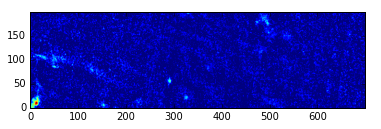

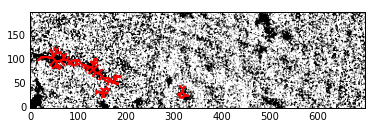

lenth of 4
1
(200, 700)
5 9


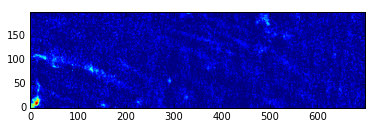

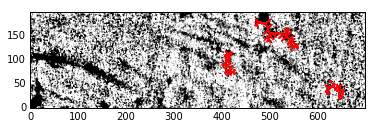

lenth of 2
2
(200, 700)
5 7


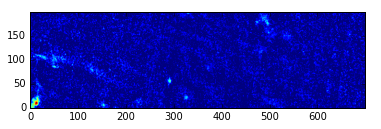

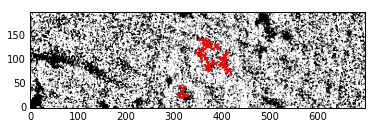

lenth of 2
4
(200, 700)
5 7


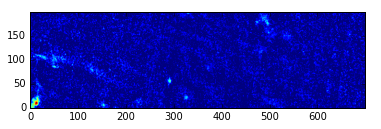

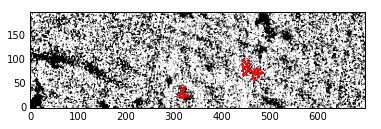

lenth of 2
6
(200, 700)
5 7


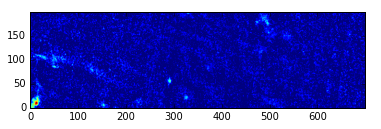

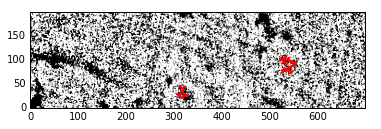

lenth of 2
8
(200, 700)
5 7


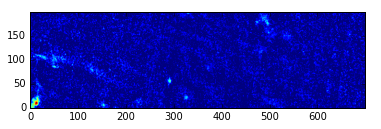

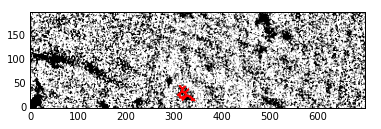

lenth of 2
9
(200, 700)
6 8


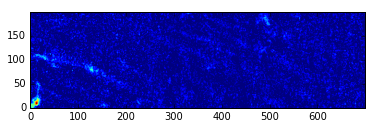

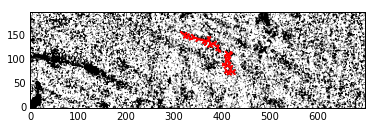

lenth of 2
11
(200, 700)
6 8


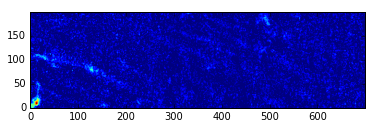

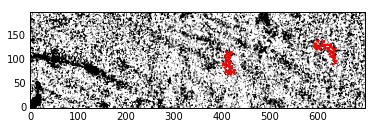

lenth of 2
14
(200, 700)
7 9


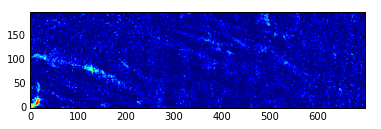

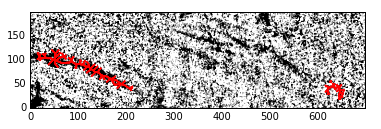

lenth of 2
15
(200, 700)
7 9


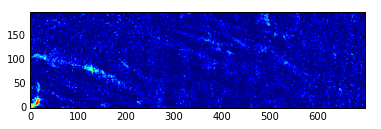

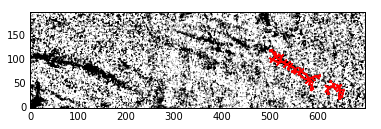

lenth of 2
16
(200, 700)
7 9


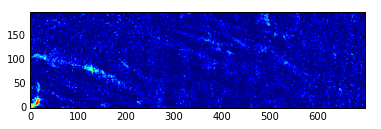

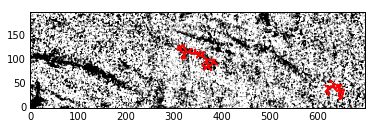

lenth of 2
17
(200, 700)
7 9


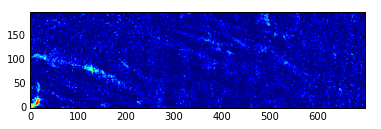

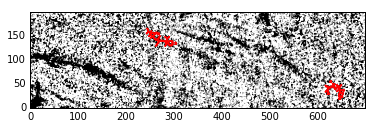

lenth of 2
18
(200, 700)
7 9


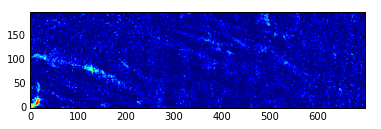

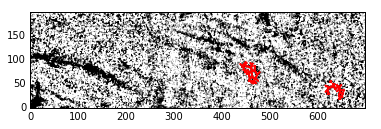

lenth of 2
19
(200, 700)
7 9


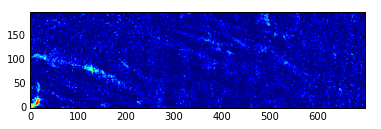

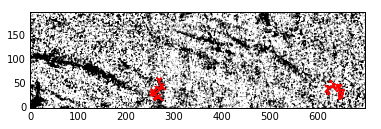

lenth of 3
24
(200, 700)
9 12


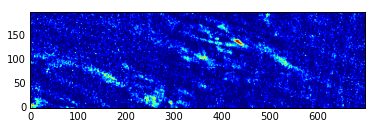

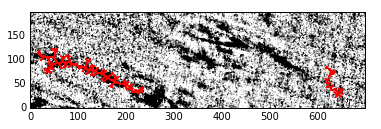

lenth of 2
25
(200, 700)
9 11


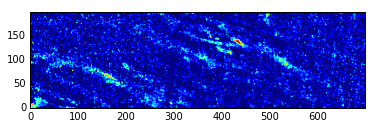

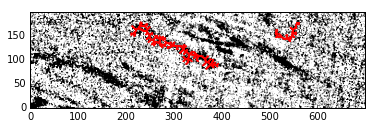

lenth of 2
26
(200, 700)
9 11


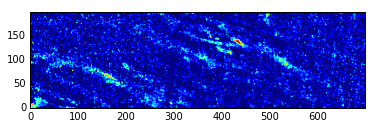

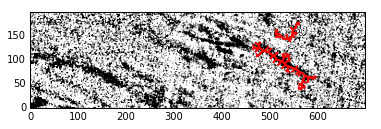

lenth of 2
29
(200, 700)
9 11


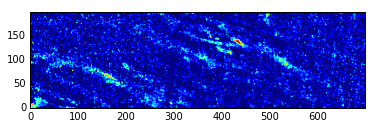

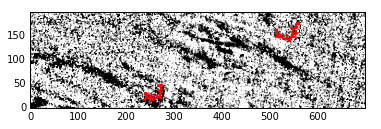

In [131]:
for tree in nodes_by_tree:
    if tree.length < 2:
        continue
    else:
        print "lenth of %d" % tree.length
        print nodes_by_tree.index(tree)
        intensity_map = createIntIntensityMap(tree.root_v_slice, tree.root_v_slice+tree.length)
        imgplot = plt.imshow(intensity_map, origin='lower')
        plt.show()
        fil_tree = filfind.fil_finder_2D(intensity_map, header=hdr, beamwidth=10.0, glob_thresh=20,
                                 distance=100, flatten_thresh=95, standard_width=1.1,
                                 size_thresh=1000, mask = tree.root_node.expandMask([[0,0],[x_dim, y_dim]]))
        #fil_tree.create_mask(verbose=True, regrid=False, border_masking=True)
        fil_tree.medskel(verbose=True)
